# FINANCIAL CROSS HEDGING

Many companies rely on specific assets for their operations, such as airlines
depending on jet fuel, and fluctuations in the prices of these assets directly
impact their operational expenses and overall profitability.

Due to the volatility of these asset prices, companies may face significant
financial uncertainty, leading to unpredictable costs and fluctuations in their
earnings.

To mitigate this risk, some companies engage in hedging by using financial
instruments like futures contracts, allowing them to lock in asset prices;
while this does not change the expected cost, it significantly reduces
variance and stabilizes financial outcomes.

The airline industry sees fuel
(kerosene) as a key cost driver,
making up about 24.7% of total
operating expenses on average. This situation highlights the need for the previously mentioned risk
management strategy: hedging, where airlines can use financial instruments
to lock in kerosene prices and reduce exposure to market fluctuations.
But, there is a problem...
In financial markets, there is no direct futures contract for kerosene, making
it impossible for airlines to hedge their positions in a conventional way...

When no direct futures contract exists for an asset, companies can hedge
using a correlated asset, a strategy known as cross-hedging.
Kerosene is a derivative of crude oil, meaning its price closely follows oil
price movements, making oil futures a potential hedging instrument.
Since crude oil futures are widely traded, we will be showing how airlines can
use them as a proxy hedge to reduce exposure to kerosene price volatility.

Cross-hedging involves a time series regression analysis to determine the
relationship between the price of the asset being hedged (kerosene) and the
price of a correlated financial instrument (such as oil futures).
There are multiple oil-related financial products available in the market,
including crude oil futures, heating oil futures, and gas oil futures, each with
varying degrees of correlation to kerosene prices.
To optimize the hedging strategy, we will analyze these different financial
products and select the one that provides the strongest and most stable
correlation with kerosene prices.

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

## Dataset

U.S. EIA + Yahoo Finance

In [2]:
df_kerosene = pd.read_csv("/Users/gio/Desktop/Book2.csv")
df_kerosene["Date"] = pd.to_datetime(df_kerosene["Date"])
df_kerosene = df_kerosene[df_kerosene["Date"] >= '2007-05-04']
df_kerosene["Date"] = df_kerosene["Date"].dt.strftime("%Y-%m-%d")

df_kerosene.head()

,Date,kerosene_price
4296,2007-05-04,2.027
4297,2007-05-07,1.992
4298,2007-05-08,2.018
4299,2007-05-09,2.008
4300,2007-05-10,2.023


In [3]:
tickers = {
    "Brent_Crude_Oil": "BZ=F",       # Brent Crude Oil (ICE)
    "WTI_Crude_Oil": "CL=F",         # West Texas Intermediate (NYMEX)
    "Heating_Oil": "HO=F",           # Heating Oil (NYMEX)
    "Gasoline_RBOB": "RB=F"          # Gasoline (RBOB - NYMEX)
}

x_data = {name: yf.download(ticker, start="2007-05-04", interval="1d")['Adj Close'] for name, ticker in tickers.items()}
df_futures = pd.DataFrame(x_data).reset_index()

df_futures.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Date,Brent_Crude_Oil,WTI_Crude_Oil,Heating_Oil,Gasoline_RBOB
0,2007-05-04,NaN,61.930000,1.8309,2.2164
1,2007-05-07,NaN,61.470001,1.8029,2.1896
2,2007-05-08,NaN,62.259998,1.8299,2.2045
3,2007-05-09,NaN,61.549999,1.8158,2.2309
4,2007-05-10,NaN,61.810001,1.8625,2.3261


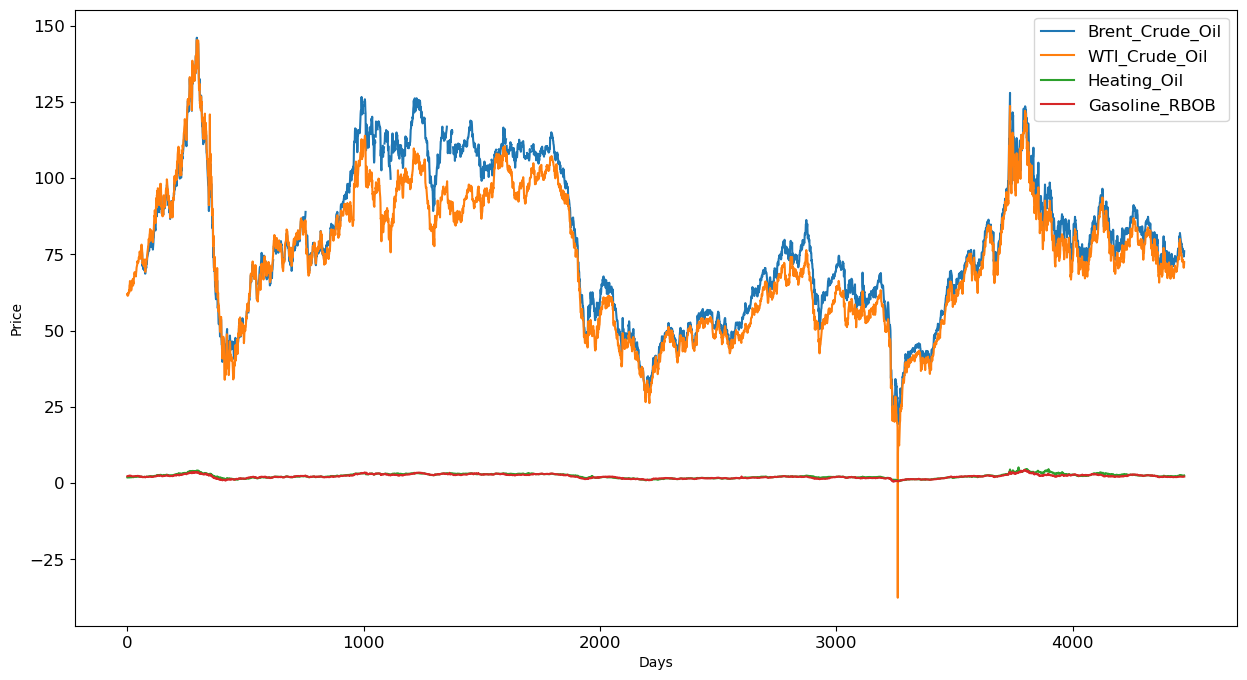

In [4]:
df_futures_plot = df_futures.drop(columns= ['Date'])

df_futures_plot.plot(figsize=(15,8),fontsize=12)
plt.legend(fontsize=12)
plt.ylabel('Price')
plt.xlabel('Days')
plt.show()

On april 2020, the price of oil fell below 0 --> no good for log return, therefore we drop those few days.

In [5]:
df_kerosene["Date"] = pd.to_datetime(df_kerosene["Date"])
df_futures["Date"] = pd.to_datetime(df_futures["Date"])

df_KF = pd.merge(df_kerosene, df_futures, on="Date", how="inner")  

df_KF.head()

,Date,kerosene_price,Brent_Crude_Oil,WTI_Crude_Oil,Heating_Oil,Gasoline_RBOB
0,2007-05-04,2.027,NaN,61.930000,1.8309,2.2164
1,2007-05-07,1.992,NaN,61.470001,1.8029,2.1896
2,2007-05-08,2.018,NaN,62.259998,1.8299,2.2045
3,2007-05-09,2.008,NaN,61.549999,1.8158,2.2309
4,2007-05-10,2.023,NaN,61.810001,1.8625,2.3261


In [ ]:
price_columns = df_KF.columns.drop("Date")

df_log_returns = df_KF.copy()  
df_log_returns[price_columns] = np.log(df_KF[price_columns] / df_KF[price_columns].shift(1))


df_log_returns.dropna(inplace=True)

df_log_returns.head()

/opt/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


,Date,kerosene_price,Brent_Crude_Oil,WTI_Crude_Oil,Heating_Oil,Gasoline_RBOB
60,2007-07-31,0.020686,0.017148,0.017802,0.016759,0.026123
61,2007-08-01,-0.020221,-0.022311,-0.021715,-0.014679,-0.053341
62,2007-08-02,-0.002324,0.005427,0.004303,0.002510,0.003247
63,2007-08-03,-0.020687,-0.013421,-0.018118,-0.019764,-0.003542
64,2007-08-06,-0.047176,-0.049078,-0.046369,-0.047677,-0.052150


In [7]:
df_log_returns.corr()

,Date,kerosene_price,Brent_Crude_Oil,WTI_Crude_Oil,Heating_Oil,Gasoline_RBOB
Date,1.000000,0.005112,0.006904,0.007956,0.003939,0.003145
kerosene_price,0.005112,1.000000,0.695323,0.656204,0.817383,0.611396
Brent_Crude_Oil,0.006904,0.695323,1.000000,0.881599,0.824061,0.745210
WTI_Crude_Oil,0.007956,0.656204,0.881599,1.000000,0.748267,0.693704
Heating_Oil,0.003939,0.817383,0.824061,0.748267,1.000000,0.690783
Gasoline_RBOB,0.003145,0.611396,0.745210,0.693704,0.690783,1.000000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


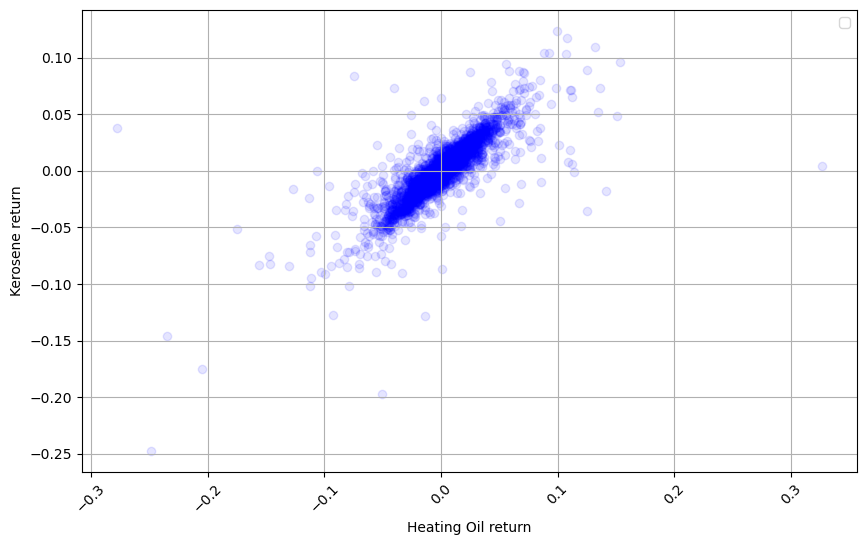

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(df_log_returns["kerosene_price"], df_log_returns["Heating_Oil"], color="blue", alpha=0.1)



plt.xlabel("Heating Oil return")
plt.ylabel("Kerosene return")
plt.legend()
plt.xticks(rotation=45)  
plt.grid(True)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


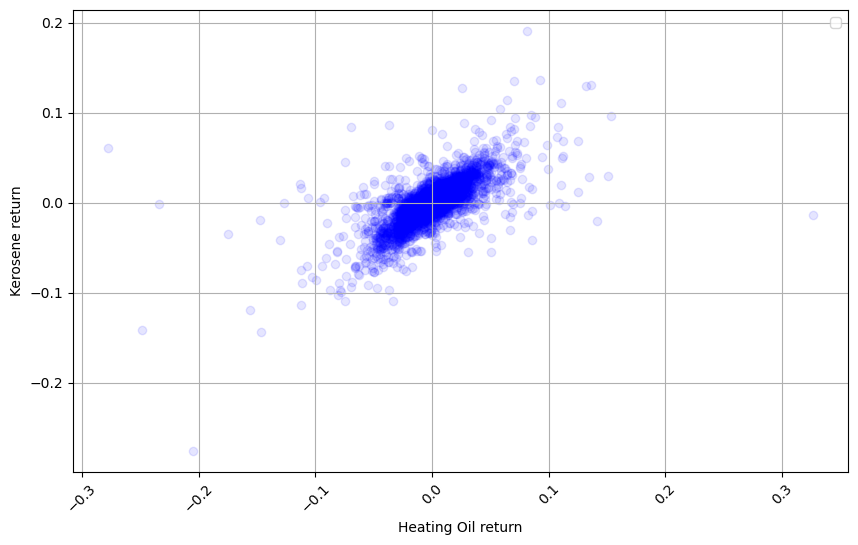

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(df_log_returns["kerosene_price"], df_log_returns["Brent_Crude_Oil"], color="blue", alpha=0.1)



plt.xlabel("Heating Oil return")
plt.ylabel("Kerosene return")
plt.legend()
plt.xticks(rotation=45)  
plt.grid(True)

plt.show()

## TIME SERIE ANALYSIS - OLS MODELS

[Ckecking assumption]

Breush-Pagan test: \
H0: Homoskedasticity \
H1: Heteroskedasticity \
p-value: 0.73 ( > 0.05) (fail to reject) 

Durbin-Watson test statistic: 2.28 \
Value close to 2 -> no evidence of \
serial correlation in the residuals. 

Shapiro test: \
H0: Sample normally distributed \
H1: Sample not normally distributed \
p-value: 0.00 ( < 0.05) (reject) \
Not too concerning due to CLT




OLS Time Serie regression (just one contract)

$$R_K = \beta_0 + \beta_1 \cdot R_{HO} + \epsilon$$

In [10]:
from sklearn.model_selection import train_test_split


Y = df_log_returns['kerosene_price'].reset_index(drop=True)
x = df_log_returns[['Heating_Oil']].reset_index(drop=True)

                            OLS Regression Results                            
Dep. Variable:         kerosene_price   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     6196.
Date:                Tue, 11 Feb 2025   Prob (F-statistic):               0.00
Time:                        00:55:28   Log-Likelihood:                 9564.3
No. Observations:                3432   AIC:                        -1.912e+04
Df Residuals:                    3430   BIC:                        -1.911e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -5.907e-06      0.000     -0.023      

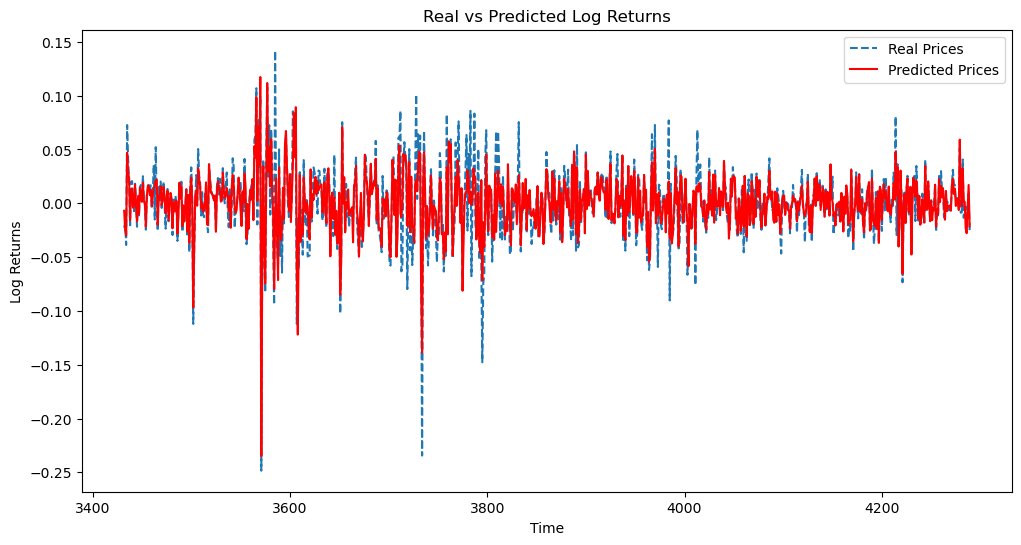

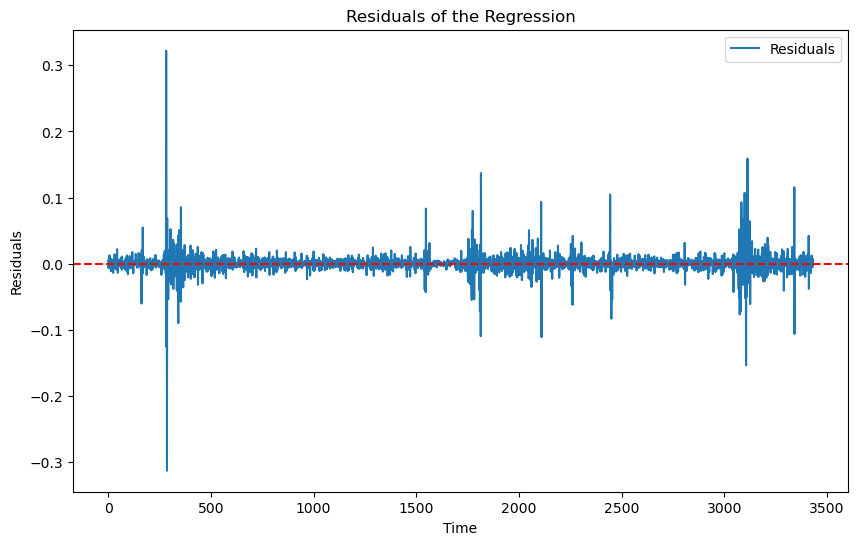

In [11]:
X = sm.add_constant(x)

train_size = int(len(X) * 0.8)  # 80% training, 20% test
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
Y_train, Y_test = Y.iloc[:train_size], Y.iloc[train_size:]

# Model
model = sm.OLS(Y_train, X_train)
results = model.fit()

print(results.summary())

Y_pred = results.predict(X_test)


# Real vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(Y_test.index, Y_test, label='Real Prices', linestyle='dashed')
plt.plot(Y_test.index, Y_pred, label='Predicted Prices', color='red')
plt.xlabel('Time')
plt.ylabel('Log Returns')
plt.title('Real vs Predicted Log Returns')
plt.legend()
plt.show()

# Residual analysis
residuals = results.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals, label="Residuals")
plt.axhline(y=0, color='r', linestyle='dashed')
plt.title('Residuals of the Regression')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()



Hedge Effetiveness (first model):
$$HE = 1-\frac{\sigma^2_{\text{hedged}}}{\sigma^2_{\text{unhedged}}}$$

$\text{Portfolio Hedged} = Y_{\text{train}} - (\beta_1 \cdot PC1 + \beta_2 \cdot PC2)$ \
$\sigma^2_{\text{hedged}} = Var(\text{Portfolio Hedged})$ \
$\sigma^2_{\text{unhedged}} = VAR(Y_{\text{train}})$

In [12]:
hedge_ratio_ho = results.params['Heating_Oil']  

portfolio_hedged_ho = Y_train - (hedge_ratio_ho * X_train['Heating_Oil'])

var_unhedged_ho = np.var(Y_train, ddof=1)
var_hedged_ho = np.var(portfolio_hedged_ho, ddof=1)

hedging_effectiveness_ho = 1 - (var_hedged_ho / var_unhedged_ho)
print(f'Hedging Effectiveness (Heating Oil) on the training set: {hedging_effectiveness_ho:.4f}')

Hedging Effectiveness (Heating Oil) on the training set: 0.6437


## Second Model

$$R_K = \beta_1 \cdot PC1 + \beta_2 \cdot PC2+ \epsilon$$

PCA

In [13]:

# Standardization
features = df_log_returns[['Heating_Oil', 'Brent_Crude_Oil']].reset_index(drop=True)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(features_scaled)
print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.9120305 0.0879695]


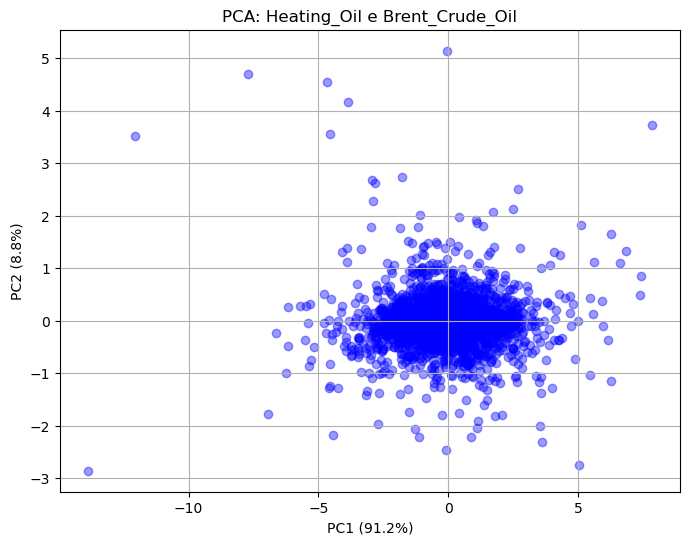

In [14]:
pca_df = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])


Y = df_log_returns['kerosene_price'].reset_index(drop=True)
X = pca_df

train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
Y_train, Y_test = Y.iloc[:train_size], Y.iloc[train_size:]

plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.4, color='blue')

plt.xlabel('PC1 ({}%)'.format(round(pca.explained_variance_ratio_[0]*100, 2)))
plt.ylabel('PC2 ({}%)'.format(round(pca.explained_variance_ratio_[1]*100, 2)))
plt.title('PCA: Heating_Oil e Brent_Crude_Oil')
plt.grid(True)
plt.show()


                                 OLS Regression Results                                
Dep. Variable:         kerosene_price   R-squared (uncentered):                   0.649
Model:                            OLS   Adj. R-squared (uncentered):              0.649
Method:                 Least Squares   F-statistic:                              3173.
Date:                Tue, 11 Feb 2025   Prob (F-statistic):                        0.00
Time:                        00:55:28   Log-Likelihood:                          9590.9
No. Observations:                3432   AIC:                                 -1.918e+04
Df Residuals:                    3430   BIC:                                 -1.917e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

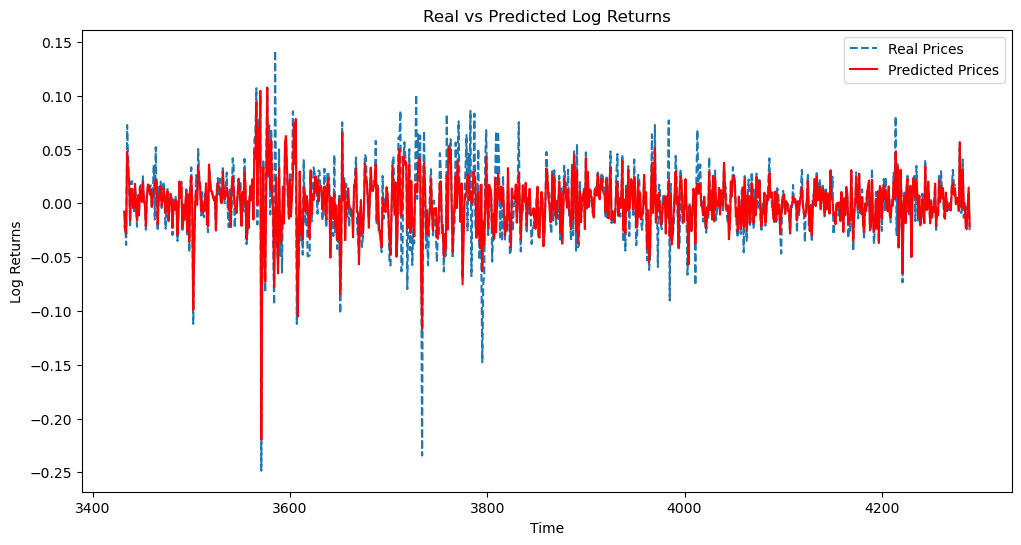

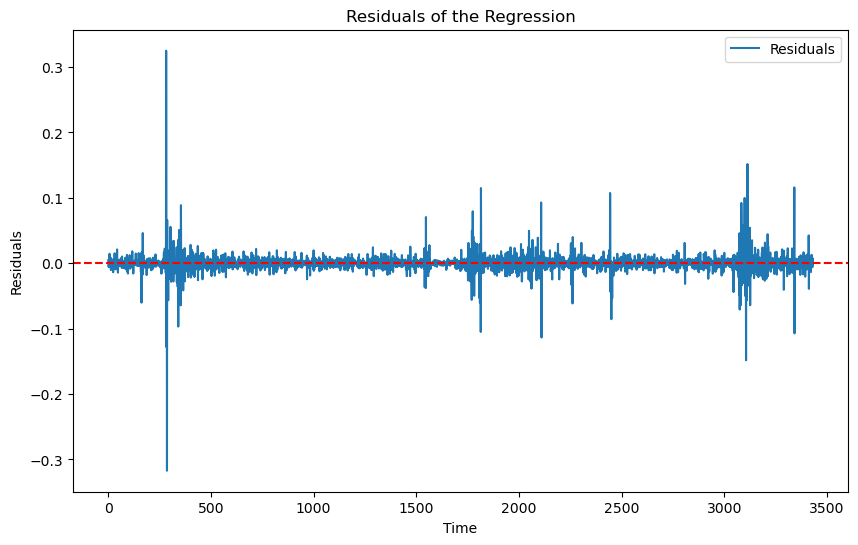

In [15]:
# Model
model = sm.OLS(Y_train, X_train)
results = model.fit()
print(results.summary())

Y_pred = results.predict(X_test)


plt.figure(figsize=(12, 6))
plt.plot(Y_test.index, Y_test, label='Real Prices', linestyle='dashed')
plt.plot(Y_test.index, Y_pred, label='Predicted Prices', color='red')
plt.xlabel('Time')
plt.ylabel('Log Returns')
plt.title('Real vs Predicted Log Returns')
plt.legend()
plt.show()

residuals = results.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals, label="Residuals")
plt.axhline(y=0, color='r', linestyle='dashed')
plt.title('Residuals of the Regression')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()


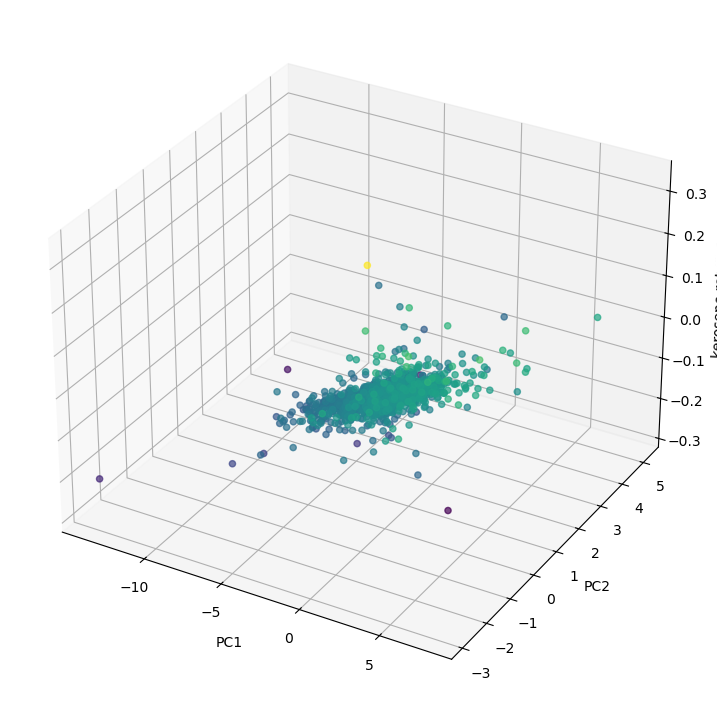

In [16]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111, projection='3d')

x = pca_df['PC1']
y = pca_df['PC2']
z = df_log_returns['kerosene_price']


sc = ax.scatter(x, y, z, c=z, cmap='viridis', alpha=0.7)


ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('kerosene returns')


plt.show()

Hedge effectiveness (second model):

In [ ]:
hedge_ratio_pc1 = results.params['PC1']
hedge_ratio_pc2 = results.params['PC2']

portfolio_hedged_pca = Y_train - (hedge_ratio_pc1 * X_train['PC1'] + hedge_ratio_pc2 * X_train['PC2'])

var_unhedged_pca = np.var(Y_train, ddof=1)
var_hedged_pca = np.var(portfolio_hedged_pca, ddof=1)

hedging_effectiveness_pca = 1 - (var_hedged_pca / var_unhedged_pca)
print(f'Hedging Effectiveness (PCA) on training set: {hedging_effectiveness_pca:.4f}')

Hedging Effectiveness (PCA) on training set: 0.669


By applying the same process using **WTI Oil** instead of BRENT, we obtain a **67%** Hedging Effectiveness!!!

We have therefore shown how
a composite hedging approach (Heating Oil + BRENT) is better
than a single-contract strategy.

Our strategy is a first step towards a Mimicking Portfolio!

